In [1]:
#pip install numpy --upgrade

In [2]:
import numpy as np
import pandas as pd
import sklearn
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk import ngrams 
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

/Users/camilleduchesne/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [3]:

import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import os
import json
import csv
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import DataLoader

from tokenizers.models import BPE
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import Sequence, Lowercase
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.trainers import BpeTrainer
from transformers import GPT2TokenizerFast, GPT2Config,TFGPT2LMHeadModel
import tensorflow as tf
import numpy as np

In [4]:
def dataSplit(tup):
    n = len(tup)
    return tup[0 : (n - 1)]

def labelSplit(tup):
    n = len(tup)
    return tup[n - 1]

# get word from dictionary ID
def getWord(d, i):
    return list(d.keys())[list(d.values()).index(i)]

#this function generates random numbers for the secret
def generateSecret(length, size):
    secret = ""
    for i in range(length):
        a = randint(0, size)
        if a < 10:
            a = "0" + str(a)
        a = str(a)
        secret = secret + a + " "
    
    return secret[:-1]

#allows us to add every secret permutation to the "test" data set, allowing us to see what probability the model assigns to every value of r
def enumerateSecrets(length, size, rid, pref):
    d = []
    
    if length == 1:
        for i in range(size):
            a = pref + str(i)
            d.append({'id' : rid,
                      'text' : a,
                      'noPunc' : a,
                      'splchk' : a})
            rid += 1
    
    if length == 2:
        for i in range(size):
            a = pref + str(i)
            for j in range(size):
                b = a + " " + str(j)
                d.append({'id' : rid,
                          'text' : b,
                          'noPunc' : b,
                          'splchk' : b})
                rid += 1
                
    return d, rid

def numericProbs_gpt(x, size, dictionary, gramSize, model, index): 
    xn = np.zeros((1, gramSize), dtype = float)
    for k in range(gramSize):
        xn[0][k] = x[index][k]

    p0 = model.predict(xn)[0]
    
    numericProbs_gpt = np.zeros((size), dtype = float)
    
    for j in range(size):
        a = str(j)
        numericProbs_gpt[j] = p0[dictionary[a]]
        
    return numericProbs_gpt


## Data Cleaning & Processing

In [5]:
f = open('smsCorpus_en_2015.03.09_all.json')
data = json.load(f)
with open("smsCorpus_en_2015.03.09_all.json") as f:
    data = json.load(f)

In [6]:
listofDict = data['smsCorpus']['message']
print(len(listofDict))
fullData = pd.DataFrame(listofDict)
dataRaw = fullData[['@id','text']]
dataRaw = pd.DataFrame(dataRaw)
dataRaw['text'] = dataRaw['text'].astype("str")
dataRaw['text'] = dataRaw['text'].map(lambda x: x.lstrip("{'$':-").rstrip("-'}"))
dataRaw['text'] = dataRaw['text'].str.replace(r"'", "")
dataRaw.head()

55835


,@id,text
0,10120,Bugis oso near wat...
1,10121,"Go until jurong point, crazy.. Available only..."
2,10122,I dunno until when... Lets go learn pilates...
3,10123,Den only weekdays got special price... Haiz.....
4,10124,Meet after lunch la...


In [7]:
import numpy as np
import re
from random import randint

def cleanSMS(sms):
    
    # leetspeak
    sms = re.sub("[\.,]", " ", sms)
    sms = re.sub(" {2,}", " ", sms)
    sms = re.sub(" 2 ", " to ", sms)
    sms = re.sub(" 4 | fr ", " for ", sms)
    
    sms = re.sub(" abt ", " about ", sms)
    sms = re.sub(" aft ", " after ", sms)
    sms = re.sub(" ard ", " around ", sms)
    
    sms = re.sub(" ar ", " all right ", sms)
    sms = re.sub(" ar$", " all right", sms)
    
    sms = re.sub(" b ", " be ", sms)
    sms = re.sub(" bcz ", " because ", sms)
    sms = re.sub(" bday ", " birthday", sms)
    sms = re.sub(" brin ", " bring ", sms)
    
    sms = re.sub(" btw ", " by the way ", sms)
    sms = re.sub(" btw$", " by the way", sms)
    
    sms = re.sub(" buk ", " book ", sms)
    
    sms = re.sub(" c ", " see ", sms)
    sms = re.sub("^c ", "see ", sms)
    
    sms = re.sub(" coz | cuz | cos ", " cause ", sms)
    sms = re.sub("^coz |^cuz |^cos ", "cause ", sms)
    
    sms = re.sub(" da ", " the ", sms)
    sms = re.sub(" dat ", " that ", sms)
    
    sms = re.sub(" den ", " then ", sms)
    sms = re.sub("^den ", "then ", sms)
    sms = re.sub(" den$", " then", sms)
    
    sms = re.sub(" dint? ", " did not ", sms)
    
    sms = re.sub(" dis ", " this ", sms)
    sms = re.sub(" dis$", " this", sms)
    
    sms = re.sub(" dem | dm ", " them ", sms)
    sms = re.sub(" dey ", " they ", sms)
    sms = re.sub("^dey ", "they ", sms)
    sms = re.sub(" dnt ", " do not ", sms)
    
    sms = re.sub(" dun | don ", " do not ", sms)
    sms = re.sub("^dun |^don ", "do not ", sms)
    sms = re.sub(" dun$| don$", " do not", sms)
    
    sms = re.sub(" e ", " the ", sms)
    sms = re.sub(" esp " , " especially ", sms)
    sms = re.sub(" enuff ", " enough ", sms)
    sms = re.sub(" frens ", " friends ", sms)
    
    sms = re.sub(" fren " , " friend ", sms)
    sms = re.sub(" fren$", " fren", sms)
    
    sms = re.sub(" frm ", " from ", sms)
    
    sms = re.sub(" gd ", " good ", sms)
    sms = re.sub("^gd ", "good ", sms)
    sms = re.sub(" gd$", " good", sms)
    
    sms = re.sub(" gn ", " good night ", sms)
    sms = re.sub("^gn ", "good night ", sms)
    sms = re.sub(" gn$", " good night", sms)
    
    sms = re.sub("^hai ", "hey ", sms)
    
    sms = re.sub(" haf | hv | hav ", " have ", sms)
    sms = re.sub(" haf$| hv$| hav$", " have", sms)
    
    sms = re.sub(" haven ", " have not ", sms)
    
    sms = re.sub(" hse ", " house ", sms)
    sms = re.sub(" hse$", " house", sms)
    sms = re.sub(" hw ", " homework ", sms)
    sms = re.sub("^hw ", "how ", sms)
    
    sms = re.sub(" i ll ", " i will ", sms)
    sms = re.sub("^i ll ", "i will ", sms)
    sms = re.sub(" i ve ", " i have ", sms)
    sms = re.sub("^i ve ", "i have ", sms)
    
    sms = re.sub(" juz | jus | jos ", " just ", sms)
    sms = re.sub("^juz |^jus |^jos ", "just ", sms)
    
    sms = re.sub("kd ", "ked ", sms)
    sms = re.sub(" knw ", " know ", sms)
    
    sms = re.sub(" lar | lter ", " later ", sms)
    sms = re.sub(" lar$| lter$", " later", sms)
    sms = re.sub("^lar |^lter ", "later ", sms)
    
    sms = re.sub(" lib ", " library ", sms)
    sms = re.sub(" lib$", " library", sms)
    
    sms = re.sub(" lect ", " lecture ", sms)
    sms = re.sub("^ll ", "i will ", sms)
    sms = re.sub(" lyk ", " like ", sms)
    sms = re.sub(" m ", " am ", sms)
    sms = re.sub("^m ", "i am ", sms)
    sms = re.sub(" mayb ", " maybe ", sms)
    sms = re.sub(" meh ", " me ", sms)
    sms = re.sub(" msg ", " message ", sms)
    sms = re.sub(" neva ", " never ", sms)
    sms = re.sub(" mum ", " mom ", sms)
    sms = re.sub(" muz ", " must ", sms)
    sms = re.sub(" n ", " and ", sms)
    sms = re.sub("nd ", "ned ", sms)
    sms = re.sub(" nite ", " night ", sms)
    sms = re.sub(" noe ", " know ", sms)
    
    sms = re.sub(" nt ", " not ", sms)
    sms = re.sub("^nt ", "not ", sms)
    
    sms = re.sub(" nvm ", " never mind ", sms)
    sms = re.sub(" nvr ", " never ", sms)
    sms = re.sub(" nw ", " now ", sms)
    
    sms = re.sub(" nxt ", " next ", sms)
    sms = re.sub("^nxt ", "next ", sms)
    
    sms = re.sub(" okie | ok | k ", " okay ", sms)
    sms = re.sub("^okie |^ok |^k ", "okay ", sms)
    sms = re.sub(" okie$| ok$| k$", " okay", sms)
    
    sms = re.sub(" oredi | alr ", " already ", sms)
    sms = re.sub(" oredi$| alr$", " already", sms)
    
    sms = re.sub(" oso ", " also ", sms)
    
    sms = re.sub(" plz ", " please ", sms)
    sms = re.sub("^plz ", "please ", sms)
    sms = re.sub(" plz$", " please", sms)
    
    sms = re.sub(" pple? ", " people ", sms)
    
    sms = re.sub(" pg ", " page ", sms)
    sms = re.sub(" pg$", " page", sms)
    
    sms = re.sub(" r ", " are ", sms)
    sms = re.sub("^r ", "are ", sms)
    sms = re.sub(" r$", " are", sms)
    
    sms = re.sub(" rem ", " remember ", sms)
    sms = re.sub(" rite ", " right ", sms)
    
    sms = re.sub(" rly ", " really ", sms)
    sms = re.sub("^rly ", "really ", sms)
    sms = re.sub(" rly$", " really", sms)
    
    sms = re.sub(" ru ", " are you ", sms)
    sms = re.sub(" s ", " is ", sms)
    sms = re.sub("^s ", "its ", sms)
    
    sms = re.sub(" sch ", " school ", sms)
    sms = re.sub(" sch$", " school", sms)
    
    sms = re.sub(" shd | shld ", " should ", sms)
    sms = re.sub(" slp ", " sleep ", sms)
    
    sms = re.sub(" sme", " some", sms)
    sms = re.sub("^sme", "some", sms)
    
    sms = re.sub(" smth ", " something ", sms)
    
    sms = re.sub(" tat ", " that ", sms)
    sms = re.sub("^tat ", "that ", sms)
    sms = re.sub(" tat$", " that", sms)
    
    sms = re.sub(" tmr | tml ", " tomorrow ", sms)
    sms = re.sub("^tmr |^tml ", "tomorrow ", sms)
    sms = re.sub(" tmr$| tml$", " tomorrow", sms)
    
    sms = re.sub(" thanx ", " thanks ", sms)
    sms = re.sub(" thanx$", " thanks", sms)
    sms = re.sub("^thanx ", "thanks ", sms)
    
    sms = re.sub(" thgt ", " thought ", sms)
    sms = re.sub(" thk | thnk ", " think ", sms)
    
    sms = re.sub(" tis ", " this ", sms)
    sms = re.sub(" tot " , " thought ", sms)
    sms = re.sub(" ttyl$", " talk to you later", sms)
    
    sms = re.sub(" tym ", " time ", sms)
    sms = re.sub(" tym", " time", sms)
    
    sms = re.sub(" [uüü] ", " you ", sms)
    sms = re.sub("^[uüü] ", "you ", sms)
    sms = re.sub(" [uüü]$", " you", sms)
    
    sms = re.sub(" ur ", " your ", sms)
    sms = re.sub(" v ", " very ", sms)
    sms = re.sub(" vil ", " will ", sms)
    sms = re.sub("^ve ", "i have ", sms)
    sms = re.sub(" wan ", " want ", sms)
    sms = re.sub(" w ", " with ", sms)
    
    sms = re.sub(" wana ", " wanna ", sms)
    sms = re.sub("^wana ", "wanna ", sms)
    
    sms = re.sub(" wat ", " what ", sms)
    sms = re.sub("^wat ", "what ", sms)
    sms = re.sub(" wat$", " what", sms)
    
    sms = re.sub(" wen ", " when ", sms)
    sms = re.sub("^wen ", "when ", sms)
    
    sms = re.sub(" wif | wid | wth ", " with ", sms)
    sms = re.sub("^wif |^wid |^wth ", "with ", sms)
    sms = re.sub(" wif$| wid$| wth$", " with", sms)
    
    sms = re.sub(" wk ", " week ", sms)

    sms = re.sub(" wun ", " wont ", sms)
    
    sms = re.sub(" y ", " why ", sms)
    sms = re.sub("^y ", "why ", sms)
    sms = re.sub(" y$", " why", sms)
    
    sms = re.sub("yup", "yep", sms)

    # remove laughter and smiles
    sms = re.sub(" d ", " ", sms)
    sms = re.sub(" d$", "", sms)
    sms = re.sub("^d ", "", sms)
    sms = re.sub(" ha ", " ", sms)
    sms = re.sub("^ha ", "", sms)
    sms = re.sub(" ha$, ", "", sms)
    sms = re.sub(" lor ", " ", sms)
    sms = re.sub(" lor$", "", sms)
    sms = re.sub(" lols? ", " ", sms)
    sms = re.sub("^lols? ", "", sms)
    sms = re.sub(" lols?$", "", sms)
    sms = re.sub("a*(ha){2,}h*", "", sms)
    sms = re.sub(" hee ", " ", sms)
    sms = re.sub("^hee ", "", sms)
    sms = re.sub(" hee$", "", sms)
    
    # remove words I don't understand
    sms = re.sub(" lei ", " ", sms)
    sms = re.sub("^lei ", " ", sms)
    sms = re.sub(" lei$", " ", sms)
    
    # standardize most '-ing' to '-in'
    sms = re.sub("(?<=[bdfghklmnoprstvwy])ing(?= )", "in", sms)
    sms = re.sub("(?<=[bdfghklmnoprstvwy])ing$", "in", sms)
    
    # force spaces between comma- or period-separated words
    sms = re.sub("(?<=[^ ])[\.,](?=[^ ])", " ", sms)
    
    return sms

#Why do we run dataRaw['splchk'] = dataRaw['noPunc'].apply(cleanSMS) twice more??

In [8]:
dataRaw = dataRaw[:30000]
rootId = len(dataRaw)
#cleaning
myPunc = '!"#$%&\()*+-/:;<=>?@[\\]^_`{|}~\''
dataRaw['noPunc'] = dataRaw['text'].apply(lambda s: s.translate(str.maketrans('','', myPunc)).lower())
dataRaw['splchk'] = dataRaw['noPunc'].apply(cleanSMS)
#cleaning
dataRaw['splchk'] = dataRaw['noPunc'].apply(cleanSMS)
dataRaw['splchk'] = dataRaw['splchk'].apply(cleanSMS)

In [9]:
random.seed(10)
#we have 20% of the whole data known as dataRaw for test and it is knwon as dataRawT
#then the othe 80% is known as dataRawR will soon split to valid and train
mskTrain = np.random.rand(len(dataRaw)) < 0.8
dataRawR = dataRaw[mskTrain]
dataRawT = dataRaw[~mskTrain]

# train-validation split
mskVal = np.random.rand(len(dataRawR)) < 0.8
#Here from the left 80% of the data in dataRawR we have 80% for training known as dataRawR and 20% for validation known as dataRawV
dataRawV = dataRawR[~mskVal]
dataRawR = dataRawR[mskVal]

In [10]:
# 0. EXPERIMENTAL SETUP ====================================

# how many copies of the secret do we insert?
numTrueSecrets = 200
# how many 'noisy' secrets do we insert?
numFalseSecrets = 2
# how many ticks are on our lock?
numDistinctValues = 100
# how long should we train the model?
numEpochs = 5
batchSize = 256

# what form should the secret take?
secretPref = "my permanent code is "
seqLength = len(secretPref.split())
gramSize = seqLength + 1

# randomness space
secretLength = 2
bigR = numDistinctValues ** secretLength

# generate a random secret
secretText = generateSecret(secretLength, numDistinctValues)
insertedSecret = secretPref + secretText

print("\n+---------------------------------------+")
print("| THANK YOU FOR USING THE SECRET SHARER |")
print("+---------------------------------------+\n")
print(" True secrets inserted:", numTrueSecrets)
print(" False secrets inserted:", numFalseSecrets)
print(" Randomness space:", numDistinctValues)
print(" Training epochs:", numEpochs)
print(" Batch size:", batchSize)
print(" Secret text: '", insertedSecret, "'\n", sep = '')
print("-----------------------------------------")
print("\npreparing data...")



+---------------------------------------+
| THANK YOU FOR USING THE SECRET SHARER |
+---------------------------------------+

 True secrets inserted: 200
 False secrets inserted: 2
 Randomness space: 100
 Training epochs: 5
 Batch size: 256
 Secret text: 'my permanent code is 73 04'

-----------------------------------------

preparing data...


In [11]:
d, rootId  = enumerateSecrets(secretLength, numDistinctValues, rootId, secretPref)

In [12]:
if numFalseSecrets > 0:
    noise = [d[i] for i in sorted(random.sample(range(len(d)), numFalseSecrets))]
    noiseDF = pd.DataFrame(noise)

In [13]:
d, rootId = enumerateSecrets(secretLength, numDistinctValues, rootId, secretPref)
#d here is all possible secrets
#for the number of false secrets that we ordered it sample from d and make a data fram with name noise out of that 
# get some noise from these fake secret to add to training

if numFalseSecrets > 0:
    noise = [d[i] for i in sorted(random.sample(range(len(d)), numFalseSecrets))]
    noiseDF = pd.DataFrame(noise)

testSecret = pd.DataFrame(d);
#test data has all possible secrets in it now
dataRawT = dataRawT.append(d)
#data for dct
dataRawdct = dataRaw.append(d)

d = []
# several in training data
for i in range(numTrueSecrets):
    d.append({'id' : rootId,
              'text' : insertedSecret,
              'noPunc' : insertedSecret,
              'splchk' : insertedSecret})
    rootId += 1
#truesecrets add in train data
trainSecret = pd.DataFrame(d)
dataRawR = dataRawR.append(d)
#also the noise is added to train set
if numFalseSecrets > 0:
    dataRawR = dataRawR.append(noiseDF)
#the train set have true sectrets and false secrets while test set has all possible secrets

# 2.4 SPLIT INTO OVERLAPPING SETS OF WORDS -----------000000

d = []
gid = 0
for i in range(len(dataRawR)):
    grams = ngrams(dataRawR.splchk.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'id' : gid,
                  'data' : g})   
        gid += 1

dataGramsR = pd.DataFrame(d)

d = []
for i in range(len(dataRawV)):
    grams = ngrams(dataRawV.splchk.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'id' : gid,
                  'data' : g})   
        gid += 1

dataGramsV = pd.DataFrame(d)

d = []
for i in range(len(dataRawT)):
    grams = ngrams(dataRawT.splchk.iloc[i].split(), gramSize)
    for g in grams:
        d.append({'id' : gid,
                  'data' : g})   
        gid += 1

dataGramsT = pd.DataFrame(d)

/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/3714986275.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRawT = dataRawT.append(d)
/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/3714986275.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRawdct = dataRaw.append(d)
/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/3714986275.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRawR = dataRawR.append(d)
/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/3714986275.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataRawR = dataRawR.append(noiseDF)


In [14]:
#create functionc to turn Golshid's df to the right format for my tokenizer

def prep_token(df):
    df['data'] = df['data'].astype(str)
    df['data']=df['data'].str.replace("(","") 
    df['data']=df['data'].str.replace(")","")
    df['data']=df['data'].str.replace(","," ")
    df['data']=df['data'].str.replace("'","")
    return df

# merge all the words together as string to find in my next function
#new_Df_test = dataGramsT
#new_Df_test = dataGramsR.apply(lambda x: x.str.replace(',', ''))
#new_Df_test
#new_Df_test['data'].str.replace(" ()","") 
#new_Df_test
#new_Df_test['data'] = new_Df_test['data'].astype(str)
#result = new_Df_test.dtypes
#new_Df_test['data']=new_Df_test['data'].str.replace("(","") 
#new_Df_test['data']=new_Df_test['data'].str.replace(")","")
#new_Df_test['data']=new_Df_test['data'].str.replace(","," ")
#new_Df_test['data']=new_Df_test['data'].str.replace("'","")

In [15]:
prep_train=prep_token(dataGramsR)
prep_test=prep_token(dataGramsT)
prep_val=prep_token(dataGramsV)

/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/1269492110.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['data']=df['data'].str.replace("(","")
/var/folders/3x/q809tzz55jq3vvvgwlrjq6kr0000gn/T/ipykernel_18303/1269492110.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['data']=df['data'].str.replace(")","")


In [16]:
#clean up, change the column name to fit the rest of the code, and drop id
prep_train=prep_train.drop(['id'],axis=1)
prep_train.columns = ['text']

prep_test=prep_test.drop(['id'],axis=1)
prep_test.columns = ['text']

prep_val=prep_val.drop(['id'],axis=1)
prep_test.columns = ['text']

In [17]:
#sanity check, works like a charm!
#prep_train
prep_test
#prep_train

,text
0,then only weekdays got special
1,only weekdays got special price
2,weekdays got special price haiz
3,got special price haiz cant
4,special price haiz cant eat
...,...
59815,permanent code is 99 97
59816,my permanent code is 99
59817,permanent code is 99 98
59818,my permanent code is 99


not sure this one is usefull anymore

In [18]:
 #TRAINING SET
#dataRawR.head() #Corresponds to the training data
#dataRawR.tail() # validate that the training set has the right amount of true tokens and the false tokens

#TEST SET
#dataRawT.head()
#dataRawT.tail()

#VALIDATION SET
#dataRawV.head()
#dataRawV.tail()

In [19]:
 #pip install numpy --upgrade

In [20]:
import os
import warnings
import re
import random
import datasets
import transformers
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from transformers import AutoTokenizer, TFGPT2LMHeadModel
from datasets import Dataset, load_dataset

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
# Log Level and suppress extensive tf warnings
os.environ["TRANSFORMERS_VERBOSITY"] = "info"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
print(transformers.__version__)

2.10.0
4.17.0


In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer
import tensorflow_hub as hub
#import tensorflow_text as text
from sklearn.model_selection import train_test_split

In [22]:
#this is based on the post-cleaned test set, for calculating the exposure metric, we need only the 4 first tokens
#The function from above was thus updated
#xt_inprocess = modif_test.values.tolist()
xt_inprocess=prep_test.values.tolist()

In [23]:
def create_xt(lst):
    res=[]
    first_1=[]
    final_first_1=[]
    list_3 = []
    text_file=[]
    for i in range(0,len(lst)):
        text_file=lst[i]
        
        for j in range(0,len(text_file)):
            first_1=re.split(" ", text_file[j])
            final_first_1 = first_1[0:4]
            joint_toget = [" ".join([str(item) for item in final_first_1])]
            res.append(joint_toget)
    
    #new_list = [lst[j:j+1] for j in range(len(lst)-stopping,len(lst))] 
    #list_3.extend(res + new_list)
    
    return res

In [24]:
xt_CD=create_xt(xt_inprocess)
#print(xt)

In [25]:
#alternative Golshid, having split each sentence into blocks of length 4, so there is more data in this one
#the names of the sets are :  (train, test, val)

prep_test
prep_val
prep_train

,text
0,go until jurong point crazy
1,until jurong point crazy available
2,jurong point crazy available only
3,point crazy available only in
4,crazy available only in bugis
...,...
130590,permanent code is 73 04
130591,my permanent code is 2
130592,permanent code is 2 43
130593,my permanent code is 94


## Tokenization

In [26]:
import datasets
from datasets import Dataset, load_dataset
stunt_double_train=prep_train.iloc[:200] ##(i made it mini for the time being)
data=Dataset.from_pandas(prep_train)

#test set
test_set =prep_test.iloc[:200]
test_set=Dataset.from_pandas(prep_test)

In [27]:
# Load tokenizer and logger
tf.get_logger().setLevel('ERROR')

MAX_TOKENS = 10
POS_TOKEN = "<|review_pos|>"
NEG_TOKEN = "<|review_neg|>"
BOS_TOKENS = [NEG_TOKEN, POS_TOKEN]
EOS_TOKEN = "<|endoftext|>"
PAD_TOKEN = "<|pad|>"

tokenizer = AutoTokenizer.from_pretrained('roberta-large',eos_token=EOS_TOKEN,
    pad_token=PAD_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True)
tokenizer.add_tokens(BOS_TOKENS, special_tokens=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

In [28]:
test_set

Dataset({
    features: ['text'],
    num_rows: 59820
})

In [29]:
output = {}
# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples, tokenizer=tokenizer):
    # Add start and end token to each comment
    examples = [ex + EOS_TOKEN for ex in examples["text"]]
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples,
        add_special_tokens=True,  # Only adds pad not eos and bos
        max_length=MAX_TOKENS,
        truncation=True,
        pad_to_max_length=True,
    )
    # shift labels for next token prediction
    # set padding token labels to -100 which is ignored in loss computation
    output["labels"] = [x[1:] for x in output["input_ids"]]
    output["labels"] = [
        [-100 if x == tokenizer.pad_token_id else x for x in y]
        for y in output["labels"]
    ]
    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


data = data.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    load_from_cache_file=True,
)
print(data)

  0%|          | 0/131 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 130595
})


In [30]:
test_set = test_set.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    load_from_cache_file=True,
)
print(test_set)

  0%|          | 0/60 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 59820
})


In [31]:
# prepare for use in tensorflow
train_tensor_inputs = tf.convert_to_tensor(data["input_ids"])
train_tensor_labels = tf.convert_to_tensor(data["labels"])
train_tensor_mask = tf.convert_to_tensor(data["attention_mask"])
train = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": train_tensor_inputs, "attention_mask": train_tensor_mask},
        train_tensor_labels,
    )
)

test_tensor_inputs = tf.convert_to_tensor(test_set["input_ids"])
test_tensor_inputs = tf.convert_to_tensor(test_set["labels"])
test_tensor_inputs = tf.convert_to_tensor(test_set["attention_mask"])
test = tf.data.Dataset.from_tensor_slices(
    (
        {"input_ids": test_tensor_inputs, "attention_mask": test_tensor_inputs},
        test_tensor_inputs,
    )
)

Metal device set to: Apple M1 Pro


2022-12-19 18:49:53.832732: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 18:49:53.833071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Fine-tuning GPT-2

In [ ]:
# Model params
BATCH_SIZE_PER_REPLICA = 256
EPOCHS = numEpochs
INITAL_LEARNING_RATE = 0.001
try:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
except NameError as e:
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA
BUFFER_SIZE = len(train)

# prepare data for consumption
train_ds = (train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True))
test_ds = test.batch(BATCH_SIZE, drop_remainder=True)

In [33]:
from tensorflow.keras import losses
import tensorflow_privacy 
from tensorflow_privacy import DPKerasAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
#from privacy.optimizers.gaussian_query import GaussianAverageQuery

In [34]:
# Drecreasing learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INITAL_LEARNING_RATE,
    decay_steps=500,
    decay_rate=0.7,
    staircase=True)

# initialize model, use_cache=False important! else wrong shape at loss calc
model = TFGPT2LMHeadModel.from_pretrained(
        "gpt2",
        use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
model.resize_token_embeddings(len(tokenizer))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tensorflow_privacy.privacy.optimizers.dp_optimizer.DPGradientDescentGaussianOptimizer(l2_norm_clip=10,noise_multiplier=1,num_microbatches=12,learning_rate=0.001)
#DPGradientDescentGaussianOptimizer this one officially has bug problems with this version

#optimizer = tensorflow_privacy.v1.DPAdamGaussianOptimize(l2_norm_clip=10,noise_multiplier=1,num_microbatches=12,learning_rate=0.001)
#optimizer=DPKerasAdamOptimizer(l2_norm_clip=10,noise_multiplier=1,num_microbatches=12)

# Create GaussianSumQuery.
#dp_sum_query = gaussian_query.GaussianSumQuery(l2_norm_clip=1.0, stddev=0.5)

# Create optimizer.
#optimizer = tensorflow_privacy.privacy.optimizers.dp_optimizer.DPAdamOptimizer(1, False)
#loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
#    labels=labels, logits=logits)

#train_op = opt.minimize(loss, global_step=global_step)

#optimizer=tf.keras.optimizers.

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])
model.compile(optimizer=optimizer, loss=[loss, *[None] * model.config.n_layer], metrics=[metric])
model.summary()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124448256 
 r)                                                              
                                                                 
Total params: 124,448,256
Trainable params: 124,448,256
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Stop training when validation acc starts dropping
# Save checkpoint of model after each period
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H%M")

PATH_BASE = "/TML_GPT2"
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    )]

In [36]:
# Train Model
steps_per_epoch = int(BUFFER_SIZE // BATCH_SIZE)
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Initial Learning rate: {INITAL_LEARNING_RATE}"
)
hist = model.fit(
    train_ds,
    validation_data=test_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Model Params:
batch_size: 256
Epochs: 5
Step p. Epoch: 510
Initial Learning rate: 0.001
Epoch 1/5


2022-12-19 18:50:01.713428: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 18:50:01.716768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


510/510 [==============================] - ETA: 0s - loss: 4.0725 - accuracy: 0.4961

2022-12-19 19:01:25.160917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


510/510 [==============================] - 784s 2s/step - loss: 4.0725 - accuracy: 0.4961 - val_loss: 13.8666 - val_accuracy: 0.0000e+00
Epoch 2/5
510/510 [==============================] - 787s 2s/step - loss: 3.1066 - accuracy: 0.5251 - val_loss: 13.9273 - val_accuracy: 0.0000e+00
Epoch 2: early stopping


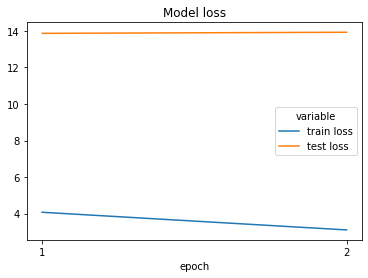

In [37]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
);

In [38]:
model.transformer.get_config()

{'name': 'transformer',
 'trainable': True,
 'dtype': 'float32',
 'config': {'vocab_size': 50268,
  'n_positions': 1024,
  'n_embd': 768,
  'n_layer': 12,
  'n_head': 12,
  'n_inner': None,
  'activation_function': 'gelu_new',
  'resid_pdrop': 0.1,
  'embd_pdrop': 0.1,
  'attn_pdrop': 0.1,
  'layer_norm_epsilon': 1e-05,
  'initializer_range': 0.02,
  'summary_type': 'cls_index',
  'summary_use_proj': True,
  'summary_activation': None,
  'summary_first_dropout': 0.1,
  'summary_proj_to_labels': True,
  'scale_attn_weights': True,
  'use_cache': False,
  'scale_attn_by_inverse_layer_idx': False,
  'reorder_and_upcast_attn': False,
  'bos_token_id': 50256,
  'eos_token_id': 50260,
  'return_dict': True,
  'output_hidden_states': False,
  'output_attentions': False,
  'torchscript': False,
  'torch_dtype': None,
  'use_bfloat16': False,
  'pruned_heads': {},
  'tie_word_embeddings': True,
  'is_encoder_decoder': False,
  'is_decoder': False,
  'cross_attention_hidden_size': None,
  'add_c





## Computing the exposure metric

In [42]:
#greedy_output = model.generate(inputs_test, max_length=50, 
#    num_beams=5, 
#    early_stopping=True
#)
#create the dictionnary 
#attention! apparently there is something about them being shifted so i need to watchout
dct_CD=tokenizer.get_vocab()

In [43]:
inputs_test=tokenizer(xt_CD[6][0], return_tensors="tf")
print(inputs_test)


{'input_ids': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[    0,  1999,  1210,  1437, 17672,  1437,     2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [44]:
def softmax(x):
    return(np.exp(x)/np.exp(x).sum())
#outputs
#softmax(x)

In [45]:
def get_prob(x,model,dictionary,size,index):
    #for a in range(0,len(x)): 
        #This chuck of code will retreive the prediction score in logits from the model
    inputs=tokenizer(x[index][0], return_tensors="tf")
    outputs = model(inputs)
    p0=outputs[0][:, -1, :]
       
    #now transfrom logits to probabilities using softmax
    p0=p0.numpy()  #transform to numpy for easier handling
    p0=softmax(p0)
        
        #join these probabilities to the vocabulary dictionnary
    new_dic={}
    for (key, value), num in zip(dictionary.items(), p0[0]): #ATTENTION: the index of [0] is to extract from cell, so we musnt change it
        new_dic.update({key:num})
        
        #here we create numericprobs vec which is vector of length 100 which is the numbers that we can have in random secre
    numericProbs_gpt = np.zeros((size), dtype = float)

        ############################################################################################################
        
        #append probabilities to vocab dictionnary
        #here we will find each number's value between 0 to 99 in the dct and then we will find its prob in p0 to be the next predicted word
        # so in numeric probs we have a vector of length 100 and probs for each number to be the next word
    for j in range(size):
        numericProbs_gpt[j] = new_dic[str(j)]
        
    return numericProbs_gpt
    

In [46]:
# 6. CALCULATE EXPOSURE ====================================

print("calculating exposure...")

# 6.1 ENUMERATE OVER EVERY POSSIBLE SECRET -----------------
#why start is this?
start = len(xt_CD)-secretLength*(numDistinctValues**secretLength)

#here we have 100 vectors of len 100
p0 = np.ones((numDistinctValues, numDistinctValues), dtype = float)
for i in range(start, len(xt_CD), 2 * numDistinctValues):
    #print(i)
    #this k creates 0 to 99 index
    k = int((i-start) / (2 * numDistinctValues))
    #print(k)
    #here in this for loop we will fill each of 100 vectors by numeric probs function
    #what is the values in numeric probs?
    #here in p0 we have 100 probs value for 100 possible numbers (from 0 to 99) that can be the next prediction
    p0[k] = get_prob(xt_CD, model, dct_CD,numDistinctValues, i)
    # this is the prediction for the next index
    # we know that a secret devide into two parts for prediction, once the first numeric value then the second
    p1 = get_prob(xt_CD, model, dct_CD,numDistinctValues,i + 1)
    # then here we have prob for a combination each time, what is the prob of observing 09 18 for example
    #the len would be 10000 since the we set numDistinctValues to 100
    # we have prob for each combination here to see after the phrase "my permanent code is"
    p0[k] = p0[k][k] * p1

    #then we sort these 
scoresRaw = np.argsort(p0, None)[::-1]

calculating exposure...


In [47]:
# 6.2 CALCULATE RANKS OF ALL SECRETS -----------------------
d = []
for i in range(len(scoresRaw)):
    d.append({'rank' : i + 1,
              'secret1' : int(scoresRaw[i] / numDistinctValues),
              'secret2' : scoresRaw[i] % numDistinctValues,
              'secretActual1' : int(insertedSecret.split()[-2]),
              'secretActual2' : int(insertedSecret.split()[-1])})

In [48]:
from math import log
#6.3 CALCULATE EXPOSURE OF INSERTED SECRET ----------------
secretRanks = pd.DataFrame(d)
secretMatch1 = secretRanks[secretRanks.secret1 == secretRanks.secretActual1]
secretMatch2 = int(secretMatch1[secretMatch1.secret2 == secretMatch1.secretActual2]['rank'])

exposure = log(bigR, 2) - log(secretMatch2, 2)

In [57]:
secretRanks

,rank,secret1,secret2,secretActual1,secretActual2
0,1,97,97,73,4
1,2,77,97,73,4
2,3,97,93,73,4
3,4,77,93,73,4
4,5,93,97,73,4
...,...,...,...,...,...
9995,9996,37,26,73,4
9996,9997,4,30,73,4
9997,9998,37,30,73,4
9998,9999,4,85,73,4


In [49]:
exposure

0.9395375120138922

## Calculating exposure for gpt-2 without finetuning

In [61]:
#no need for finetuning with the training data, only need the test set
#fetch new model and tokenizer
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")

tokenizer_raw = AutoTokenizer.from_pretrained('gpt2')
model_raw = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model_raw.compile(metrics=[metric])     

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


In [62]:
# 6. CALCULATE EXPOSURE ====================================

print("calculating exposure...")

# 6.1 ENUMERATE OVER EVERY POSSIBLE SECRET -----------------
#why start is this?
start = len(xt_CD)-secretLength*(numDistinctValues**secretLength)

#here we have 100 vectors of len 100
p0 = np.ones((numDistinctValues, numDistinctValues), dtype = float)
for i in range(start, len(xt_CD), 2 * numDistinctValues):
    #print(i)
    #this k creates 0 to 99 index
    k = int((i-start) / (2 * numDistinctValues))
    #print(k)
    #here in this for loop we will fill each of 100 vectors by numeric probs function
    #what is the values in numeric probs?
    #here in p0 we have 100 probs value for 100 possible numbers (from 0 to 99) that can be the next prediction
    p0[k] = get_prob(xt_CD, model_raw, dct_CD,numDistinctValues, i)
    # this is the prediction for the next index
    # we know that a secret devide into two parts for prediction, once the first numeric value then the second
    p1 = get_prob(xt_CD, model_raw, dct_CD,numDistinctValues,i + 1)
    # then here we have prob for a combination each time, what is the prob of observing 09 18 for example
    #the len would be 10000 since the we set numDistinctValues to 100
    # we have prob for each combination here to see after the phrase "my permanent code is"
    p0[k] = p0[k][k] * p1

    #then we sort these 
scoresRaw = np.argsort(p0, None)[::-1]

calculating exposure...


In [63]:
# 6.2 CALCULATE RANKS OF ALL SECRETS -----------------------
d = []
for i in range(len(scoresRaw)):
    d.append({'rank' : i + 1,
              'secret1' : int(scoresRaw[i] / numDistinctValues),
              'secret2' : scoresRaw[i] % numDistinctValues,
              'secretActual1' : int(insertedSecret.split()[-2]),
              'secretActual2' : int(insertedSecret.split()[-1])})

In [64]:
from math import log
#6.3 CALCULATE EXPOSURE OF INSERTED SECRET ----------------
secretRanks = pd.DataFrame(d)
secretMatch1 = secretRanks[secretRanks.secret1 == secretRanks.secretActual1]
secretMatch2 = int(secretMatch1[secretMatch1.secret2 == secretMatch1.secretActual2]['rank'])

exposure = log(bigR, 2) - log(secretMatch2, 2)

In [65]:
exposure

0.15617691087310526